In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

In [2]:
plt.style.use("seaborn-whitegrid")
plt.rcParams["axes.grid"] = False

In [3]:
Ls = [20, 50, 100, 200]
# bs = [1.651, 1.675, 1.701, 1.725, 1.749, 1.751, 1.775, 1.799, 1.801, 1.825, 1.851]
bs = [1.651, 1.675, 1.701, 1.725, 1.751, 1.775, 1.801, 1.825, 1.851]
Nfields = 40
DROP = 5*10**2
CALC = 10**4
EVERY = 100

seeds = [5,58,4785,45895,1256,65478,854,126,42,1458,458,96324,985423,85456, 4585, 8956, 8596589,89589,74,658,84,845,9,55,489, 32,456,345,876,6, 456, 34,67,444,666, 5678, 98, 65, 389, 8765]
p_c = .9 # probability of being assigned strategy C

In [6]:
for L in Ls:
    for idx, seed in enumerate(seeds):
        np.random.seed(seed)
        np.save("fields/field_{}_{}.npy".format(L, idx), np.random.choice((0, 1), (L, L), p=(1-p_c, p_c)))

In [4]:
%load_ext cython

In [5]:
%%cython
import numpy as np
cimport cython

@cython.cdivision(True)
@cython.boundscheck(False)
def evolve(long[:, :] field, double b, long num_epoch=1):
    cdef:
        int L = field.shape[0]
        int x, y, x1, x2, x3, y1, y2, y3, i, j, bestX, bestY
        double N = field.shape[0]
        long[:, :] next_state = np.zeros((L, L), dtype=int)
        double[:, :] scores = np.zeros((L, L), dtype=float)
        double[:, :] _zeros = np.zeros((L, L), dtype=float)
        double f_c
        
    assert L != 0
    
    next_state = field.copy()
    
    for _ in range(num_epoch):
        f_c = np.sum(field)/(N*N)
        scores[...] = _zeros
        for x in range(L):
            for y in range(L):
                x1, x2, x3 = (x-1)%L, x%L, (x+1)%L
                y1, y2, y3 = (y-1)%L, y%L, (y+1)%L
#                 return ((x1, x2, x3), (y1, y2, y3))
                scores[x, y] = (field[x1, y1] + field[x1, y2] + field[x1, y3] +
                                field[x2, y1] + f_c + field[x2, y3] +
                                field[x3, y1] + field[x3, y2] + field[x3, y3])
                if field[x, y] == 0:
                    scores[x, y] *= b
#         return scores
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if scores[(x+i)%L, (y+j)%L] > scores[bestX, bestY]:
                            bestX = (x+i)%L
                            bestY = (y+j)%L

                next_state[x, y] = field[bestX, bestY]
        
        field = next_state.copy()
        
    return np.asarray(field)

In [6]:
%%cython
import numpy as np
cimport cython
# 0 - D
# 1 - C
# 2 - C after D
# -2- D after C
cdef long[:, :] collors = np.array(((255, 255, 0), (0, 0, 0), (255, 0, 0), (0, 0, 255), (0, 255, 0)), dtype=int)
@cython.cdivision(True)
@cython.boundscheck(False)
def make_rgb(long[:, :] field):
    cdef:
        int L = field.shape[0]
        long[:, :, :] new_field = np.zeros((L, L, 3), dtype=int)
        
    for i in range(L):
        for j in range(L):
            for t in range(3):
                new_field[i, j, t] = collors[field[i, j]+2][t]
                
    return np.asarray(new_field)

<IPython.core.display.Javascript object>


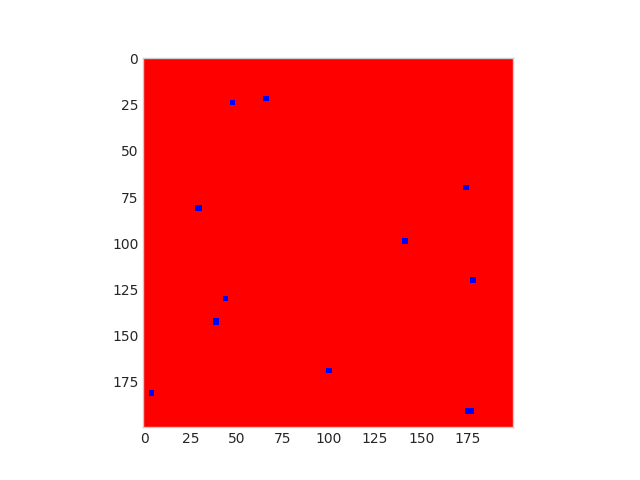

In [8]:
L = 200
p_c_ = .9
field = np.random.choice((0, 1), (L, L), p=(1-p_c_, p_c_))
# field = np.ones((L, L), dtype=int)
# field[30:32, 30:32] = np.zeros((2, 2), dtype=int)
# field[L//2, L//2] = 0

# draw the initial field
fig = plt.figure()
im = plt.imshow(make_rgb(field), animated=True, cmap=plt.get_cmap('Paired'))
# ax.grid(False)

# updater function
def updatefig(frame):
    if frame < 3:
        return im,
    global field
    field_ = evolve(field, 2.5, 1)
    coll = make_rgb(field_ + 2*(field_-field))
    field = field_.copy()
    im.set_array(coll)
    return im,

# animate!
anim = animation.FuncAnimation(fig, updatefig, frames=200, interval=150, blit=True)

plt.show()

In [8]:
field.sum()/(1.*field.shape[0]*field.shape[1])

0.902525

In [20]:
field = np.load("fields/field_200_10.npy")
d = []
for _ in tqdm(range(int(200)), total=int(200)):
    field = evolve(field, 1.7, 1)
#             print(field.sum()/(1.*50^2))
    d.append(field.sum()/(1.*field.shape[0]**2))

100%|██████████| 200/200 [00:02<00:00, 77.04it/s]


<IPython.core.display.Javascript object>


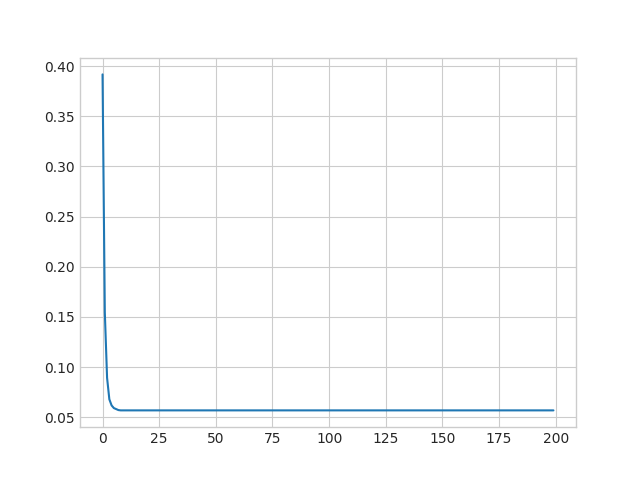

In [21]:
plt.plot(d)

In [12]:
density = []
for s in range(10, 20):
    den = []
    for b in tqdm(np.linspace(1.65, 1.85, 20)):
        d = []
        field = np.load("fields/field_200_{}.npy".format(s))
        field = evolve(field, b, 600)
        for _ in range(0, 1000):
            field = evolve(field, b)
            d.append(field.sum()/(1.*field.shape[0]*field.shape[1]))
        den.append(d)
    density.append(den)

100%|██████████| 20/20 [03:19<00:00,  9.95s/it]


In [7]:
np.save("density_L200_big.npy", np.asarray(density))

In [8]:
density = np.load("density_L200_big.npy")

In [13]:
density = np.asarray(density)

In [14]:
std = density.std(axis=-1)

In [15]:
means = density.mean(axis=-1)

<IPython.core.display.Javascript object>


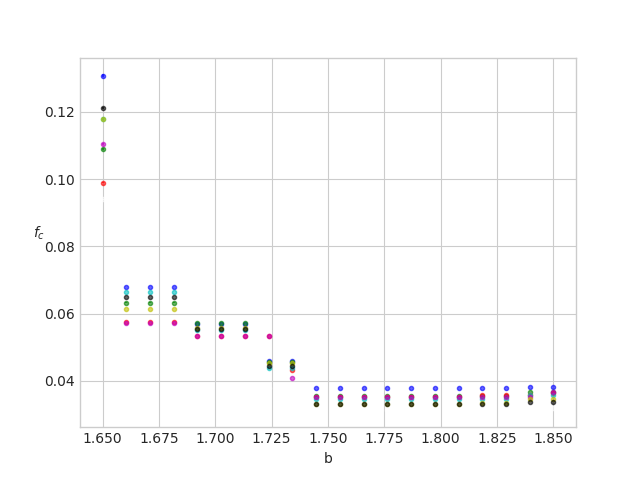

No handles with labels found to put in legend.


Text(0, 0.5, '$f_c$')

In [17]:
for i, c in enumerate(["b", "g", "r", "c", "m", "y", "k", "w"]):
    plt.errorbar(np.linspace(1.65, 1.85, 20), means[i], yerr=std[i], fmt=".{}".format(c), alpha=.6)
plt.legend(loc="upper right")
plt.xlabel("b")
# plt.yticks(np.arange(0., 1.1, .1))
plt.ylabel("$f_c$", rotation=0)
# plt.errorbar([1.650, 1.675, 1.749, 1.751, 1.799, 1.801, 1.851], means2[0], yerr=std2[0], fmt="vb--", label="L=200")
# plt.errorbar([1.7], [np.asarray(dex).mean()], fmt=">y", label="L=500")

<IPython.core.display.Javascript object>


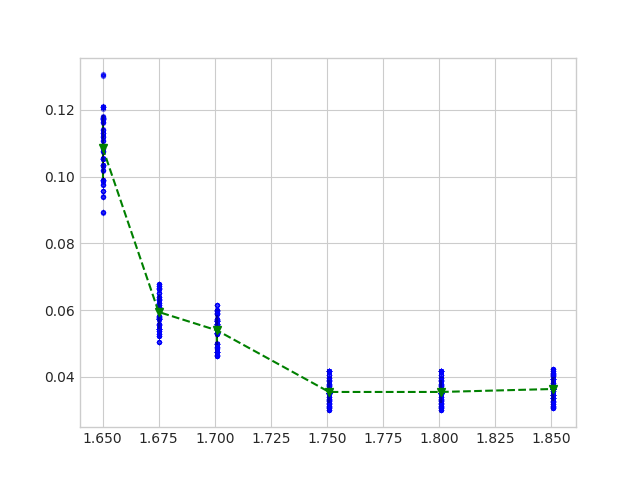

<ErrorbarContainer object of 3 artists>

In [42]:
for i, b in enumerate([1.650, 1.675, 1.701, 1.751, 1.801, 1.851]):
    plt.errorbar([b], density2[0][i], fmt=".b", alpha=0.01)

plt.errorbar(np.array([1.650, 1.675, 1.701, 1.751, 1.801, 1.851]), means2[0], yerr=std2[0], fmt="vg--", label="L=200")

In [ ]:
den2 = []
for j, b in enumerate(bs):
    den = []
    for i in range(0, 3800, 95):
        den.append(np.mean(density[2, j, i:i+95]))
    den2.append(den)